<a href="https://colab.research.google.com/github/Samplergithub769/Melanoma-Skin-Disease-Classification/blob/main/Melanoma_Skin_Disease_Classification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup and Import Libraries**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = "/content/drive/MyDrive/Split_smol"

In [4]:
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [5]:
# Print the paths to confirm they are correct

print("Base Directory:", base_dir)
print("Train Directory:", train_dir)
print("Validation Directory:", val_dir)

Base Directory: /content/drive/MyDrive/Split_smol
Train Directory: /content/drive/MyDrive/Split_smol/train
Validation Directory: /content/drive/MyDrive/Split_smol/val


**Training Data Preprocessing**

In [6]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

**Validation Data Preprocessing**

In [7]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

**We use .flow_from_directory to load images and preprocess them.**

In [8]:
#Training Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize images to 224x224
    batch_size=32,           # Load 32 images per batch
    class_mode='categorical'      # For binary classification (melanoma vs non-melanoma)
)

Found 697 images belonging to 9 classes.


In [9]:
#Validation Data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 181 images belonging to 9 classes.


[link text](https://)**Exploratory Data Analysis (EDA)**

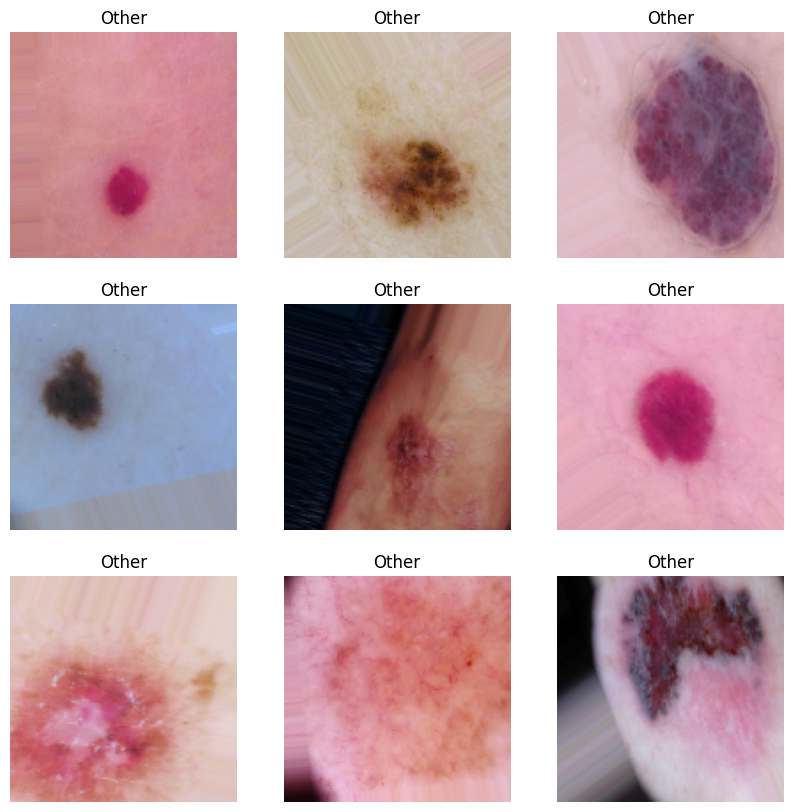

In [10]:
def visualize_samples(generator):
    images, labels = next(generator)  # Load one batch of images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        # Check if the label has the highest probability at index 0 (Melanoma)
        plt.title("Melanoma" if np.argmax(labels[i]) == 0 else "Other")
        plt.axis("off")
    plt.show()

visualize_samples(train_generator)
#next(generator): Retrieves the next batch of images and their labels.
#plt.imshow: Displays the images.
#plt.title: Sets the title based on the label (1 = melanoma, 0 = other).

In [11]:
# Check class distribution in the training set
print("Class labels:", train_generator.class_indices)
melanoma_count = len(os.listdir(os.path.join(train_dir, 'Melanoma')))
other_count = sum([len(files) for _, _, files in os.walk(train_dir)]) - melanoma_count
print(f"Melanoma Images: {melanoma_count}")
print(f"Other Images: {other_count}")


Class labels: {'Actinic keratosis': 0, 'Atopic Dermatitis': 1, 'Benign keratosis': 2, 'Dermatofibroma': 3, 'Melanocytic nevus': 4, 'Melanoma': 5, 'Squamous cell carcinoma': 6, 'Tinea Ringworm Candidiasis': 7, 'Vascular lesion': 8}
Melanoma Images: 80
Other Images: 617


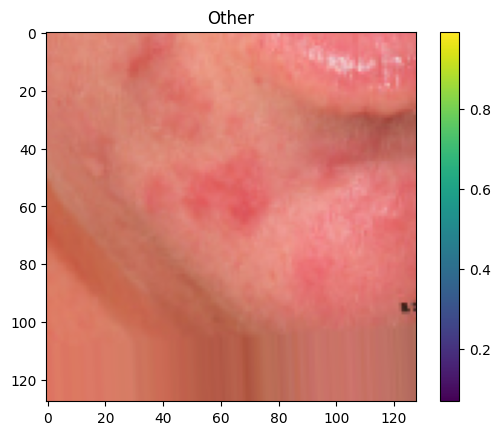

In [12]:
# Visualize one preprocessed image
images, labels = next(train_generator)
plt.imshow(images[0])
# Get the index of the predicted class
predicted_class_index = np.argmax(labels[0])
# Assuming 'Melanoma' is at index 0 in your class labels
plt.title("Melanoma" if predicted_class_index == 0 else "Other")
plt.colorbar()  # Show pixel intensity scale
plt.show()


In [13]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization,MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
cnn=tf.keras.models.Sequential()

In [15]:
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))


In [17]:

# Third Convolutional Layer
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))


In [18]:
#Flattening
cnn.add(tf.keras.layers.Flatten())

In [19]:
#Fully Connected Layer
# Fully Connected Layer
cnn.add(Dense(units=256, activation='relu'))


In [20]:
#Output Layer
cnn.add(tf.keras.layers.Dense(units=9,activation='softmax'))

In [21]:
#Compiling MOdel
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
# Define Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [23]:
cnn.fit(x= train_generator,validation_data=val_generator,epochs=25,callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 679s 31s/step - accuracy: 0.1747 - loss: 2.4802 - val_accuracy: 0.2155 - val_loss: 1.9477
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - accuracy: 0.2477 - loss: 1.9021 - val_accuracy: 0.3425 - val_loss: 1.7257
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.3458 - loss: 1.6087 - val_accuracy: 0.3481 - val_loss: 1.6885
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - accuracy: 0.3805 - loss: 1.5649 - val_accuracy: 0.3702 - val_loss: 1.5375
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - accuracy: 0.4210 - loss: 1.4097 - val_accuracy: 0.3757 - val_loss: 1.6008
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.4502 - loss: 1.3849 - val_accuracy: 0.4254 - val_loss: 1.4706
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step - accuracy: 0.4537 - loss: 1.3644 - val_accuracy: 0.3646 - val_loss: 1.7319
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.4122 - loss: 1.4798 - val_accura

In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/ISIC_0000281.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train_generator.class_indices
if result[0][0] == 1:
  prediction = 'Mellanoma'
else:
  prediction = 'Others'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


In [25]:
print(prediction)

Others


In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/ISIC_0011112.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train_generator.class_indices
if result[0][0] == 1:
  prediction = 'Mellanoma'
else:
  prediction = 'Others'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [27]:
print(prediction)

Others
